# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Ejemplo-de-dataset-de-ocupación-por-parquímetro-geolocalizado" data-toc-modified-id="Ejemplo-de-dataset-de-ocupación-por-parquímetro-geolocalizado-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ejemplo de dataset de ocupación por parquímetro geolocalizado</a></div><div class="lev2 toc-item"><a href="#Cargamos-transacciones" data-toc-modified-id="Cargamos-transacciones-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargamos transacciones</a></div><div class="lev3 toc-item"><a href="#Breve-EDA" data-toc-modified-id="Breve-EDA-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Breve EDA</a></div><div class="lev2 toc-item"><a href="#Cargamos-datos-de-ubicación" data-toc-modified-id="Cargamos-datos-de-ubicación-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cargamos datos de ubicación</a></div><div class="lev2 toc-item"><a href="#Relacionamos-los-datos-seleccionando-aquellos-parquímetros-ubicados" data-toc-modified-id="Relacionamos-los-datos-seleccionando-aquellos-parquímetros-ubicados-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Relacionamos los datos seleccionando aquellos parquímetros ubicados</a></div><div class="lev2 toc-item"><a href="#Gráfica-de-ubicaciones" data-toc-modified-id="Gráfica-de-ubicaciones-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gráfica de ubicaciones</a></div><div class="lev2 toc-item"><a href="#Generamos-las-series-timestamps-por-parquímetro" data-toc-modified-id="Generamos-las-series-timestamps-por-parquímetro-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Generamos las series timestamps por parquímetro</a></div><div class="lev3 toc-item"><a href="#Construímos-la-serie-de-ocupación-por-timestamp" data-toc-modified-id="Construímos-la-serie-de-ocupación-por-timestamp-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Construímos la serie de ocupación por timestamp</a></div><div class="lev3 toc-item"><a href="#Representamos-algún-parquímetro-y-EDA-ocupacional" data-toc-modified-id="Representamos-algún-parquímetro-y-EDA-ocupacional-152"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Representamos algún parquímetro y EDA ocupacional</a></div><div class="lev3 toc-item"><a href="#Frecuencia-media-de-actualización-de-ocupación" data-toc-modified-id="Frecuencia-media-de-actualización-de-ocupación-153"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Frecuencia media de actualización de ocupación</a></div><div class="lev3 toc-item"><a href="#Construímos-la-serie-de-ocupación-agregada" data-toc-modified-id="Construímos-la-serie-de-ocupación-agregada-154"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>Construímos la serie de ocupación agregada</a></div>

# Ejemplo de dataset de ocupación por parquímetro geolocalizado

In [1]:
import constants as ct
import numpy as np
import pandas as pd
import os
import functools
import empark.utils as utils
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import folium
import sys
from folium.plugins import MarkerCluster, HeatMapWithTime
%matplotlib inline

pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 300

In [2]:
os.listdir(ct.DATA_FOLDER)

['ParkingTransaction_20120101_20170930_cleaned.csv',
 'on_street_parkings_ids_1001_1598.json',
 'Cobertura Expendedores PALENCIA V2 Comentarios.xlsx',
 'Cobertura Expendedores VALLADOLID Comentarios.xlsx',
 'Blockface_cleaned.csv',
 'on_street_parkings_ids_1_1000_modif.json']

## Cargamos transacciones

Sacamos los datos de 2012, para sacar más datos quitar fecha de restricción

In [3]:
chunk_parser = pd.read_csv(os.path.join(ct.DATA_FOLDER, 'ParkingTransaction_20120101_20170930_cleaned.csv'), 
                           parse_dates=['TransactionDateTime'],
                           chunksize=500000)

df = None
max_rows = np.inf
counter = 0
previous_nrows = 0

for i, iteration in enumerate(chunk_parser):
    if isinstance(df, pd.DataFrame):
        df = pd.concat([df, chunk_parser.get_chunk()], axis=0)
        df = df.loc[df.TransactionDateTime.dt.year == 2012]        
        if previous_nrows == df.shape[0]:
            counter += 1
        if counter >= 3:
            break
    else:
        df = chunk_parser.get_chunk()
    previous_nrows = df.shape[0]    
    print(i, df.shape, counter)
    if df.shape[0] > max_rows:
        break

df.columns = df.columns.map(utils.camel_case_to_snake)#utils.string_cleaner)
# df.transaction_date_time = pd.to_datetime(df.transaction_date_time)
df.transaction_date = pd.to_datetime(df.transaction_date, format="%Y-%m-%d")
df.sort_values('transaction_date_time', inplace=True)

# create final date time column
df['final_date_time'] = df.transaction_date_time.add(pd.to_timedelta(df.duration_mins, unit="m"))

# optional transformation to code columns
# df.metercode = df.metercode.map(lambda s: 'c_%s' % s)
# df.metercode = df.metercode.map(lambda s: 'c_%s' % s)
df.info(memory_usage='deep')

0 (500000, 10) 0
1 (1000000, 10) 0
2 (1500000, 10) 0
3 (2000000, 10) 0
4 (2500000, 10) 0
5 (3000000, 10) 0
6 (3500000, 10) 0
7 (4000000, 10) 0
8 (4500000, 10) 0
9 (5000000, 10) 0
10 (5500000, 10) 0
11 (5500000, 10) 1
12 (5500000, 10) 2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5500000 entries, 507197 to 10987142
Data columns (total 11 columns):
transaction_id           int64
transaction_date_time    datetime64[ns]
transaction_date         datetime64[ns]
time_start               object
time_expired             object
duration_mins            int64
amount                   float64
payment_mean             object
meter_code               int64
element_key              int64
final_date_time          datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(4), object(3)
memory usage: 1.3 GB


In [4]:
df.head()

,transaction_id,transaction_date_time,transaction_date,time_start,time_expired,duration_mins,amount,payment_mean,meter_code,element_key,final_date_time
507197,14550137,2012-01-24 00:06:59,2012-01-24,00:06,02:06,120,4.0,CREDIT CARD,10269002,76986,2012-01-24 02:06:59
527058,14580904,2012-01-24 00:34:25,2012-01-24,00:34,02:34,120,4.0,CREDIT CARD,21072002,57194,2012-01-24 02:34:25
527059,14580905,2012-01-24 00:36:24,2012-01-24,00:36,01:36,60,2.0,CREDIT CARD,21072002,57194,2012-01-24 01:36:24
524148,14574122,2012-01-24 01:07:59,2012-01-24,01:07,03:07,120,4.0,CREDIT CARD,2091002,31498,2012-01-24 03:07:59
503897,14555348,2012-01-24 01:12:59,2012-01-24,01:12,03:12,120,8.0,CREDIT CARD,8003002,13093,2012-01-24 03:12:59


In [5]:
df.dtypes

transaction_id                    int64
transaction_date_time    datetime64[ns]
transaction_date         datetime64[ns]
time_start                       object
time_expired                     object
duration_mins                     int64
amount                          float64
payment_mean                     object
meter_code                        int64
element_key                       int64
final_date_time          datetime64[ns]
dtype: object

In [6]:
utils.get_null_summary(df)

payment_mean    0.000068
dtype: float64

### Breve EDA

In [7]:
df.duration_mins.describe().astype('str')

count            5500000.0
mean     83.10040109090909
std      72.04883042795103
min                    0.0
25%                   35.0
50%                   70.0
75%                  120.0
max                  720.0
Name: duration_mins, dtype: object

In [8]:
df.transaction_date.describe()

count                 5500000
unique                    191
top       2012-06-08 00:00:00
freq                    42921
first     2012-01-24 00:00:00
last      2012-12-31 00:00:00
Name: transaction_date, dtype: object

In [9]:
day_hours_count = df.transaction_date_time.dt.hour.value_counts(normalize=True).mul(100).map(lambda x: np.round(x, 4)).sort_index()
day_hours_count

0      0.0438
1      0.0336
2      0.0251
3      0.0138
4      0.0287
5      0.1172
6      0.4833
7      1.8748
8      4.9057
9      6.9790
10     8.5951
11    10.0542
12    10.6129
13     9.9416
14     9.1021
15     8.6460
16     8.4291
17     8.8719
18     6.8404
19     4.2433
22     0.0913
23     0.0673
Name: transaction_date_time, dtype: float64

Podemos considerar que los tickets se tienen entre las 6/7 y las 19 incluyendo extremos:

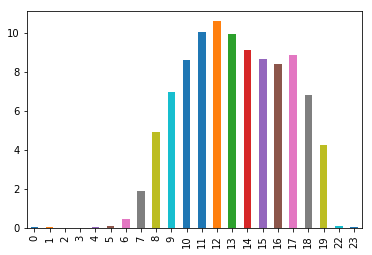

In [10]:
day_hours_count.plot(kind='bar');

Vemos como el 99.0961 % de los tickets están entre las 7 y las 19 (inclusives)

In [11]:
day_hours_count.sort_values(ascending=False).cumsum()

12     10.6129
11     20.6671
13     30.6087
14     39.7108
17     48.5827
15     57.2287
10     65.8238
16     74.2529
9      81.2319
18     88.0723
8      92.9780
19     97.2213
7      99.0961
6      99.5794
5      99.6966
22     99.7879
23     99.8552
0      99.8990
1      99.9326
4      99.9613
2      99.9864
3     100.0002
Name: transaction_date_time, dtype: float64

## Cargamos datos de ubicación

In [12]:
os.listdir(ct.DATA_FOLDER)

['ParkingTransaction_20120101_20170930_cleaned.csv',
 'on_street_parkings_ids_1001_1598.json',
 'Cobertura Expendedores PALENCIA V2 Comentarios.xlsx',
 'Cobertura Expendedores VALLADOLID Comentarios.xlsx',
 'Blockface_cleaned.csv',
 'on_street_parkings_ids_1_1000_modif.json']

In [13]:
static_data_0 = pd.read_json(os.path.join(ct.DATA_FOLDER, 'on_street_parkings_ids_1_1000_modif.json'))
static_data_1 = pd.read_json(os.path.join(ct.DATA_FOLDER, 'on_street_parkings_ids_1001_1598.json'))
static_data = pd.concat([static_data_0, static_data_1], axis=0, sort=True)

In [14]:
static_data.head()

,attributes,geometry
0,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 1.5, 'ELMNTKEY': 46257, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 284126, 'SUN_RATE2': None, 'DISTANCE': 269, 'SHAPE_LNG': -122.35553873099501, 'RECEIPT_NBR': 'S097', 'WKD_RATE1...","{'x': -13620556.267099999, 'y': 6043950.853799999}"
1,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 5, 'ELMNTKEY': 76414, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 528282, 'SUN_RATE2': None, 'DISTANCE': 163, 'SHAPE_LNG': -122.32760381418501, 'RECEIPT_NBR': 'H029', 'WKD_RATE1':...","{'x': -13617446.566399999, 'y': 6042023.201899998}"
2,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 4, 'ELMNTKEY': 57513, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 527929, 'SUN_RATE2': None, 'DISTANCE': 186, 'SHAPE_LNG': -122.33164530720201, 'RECEIPT_NBR': 'E050', 'WKD_RATE1':...","{'x': -13617896.463399999, 'y': 6042609.660400003}"
3,"{'START_TIME_SAT': None, 'END_TIME_SAT': None, 'SAT_RATE2': None, 'ELMNTKEY': 120222, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': None, 'COMPKEY': 338114, 'SUN_RATE2': None, 'DISTANCE': 60, 'SHAPE_LNG': -122.34006308416501, 'RECEIPT_NBR': 'T010', 'WKD_RATE1': ...","{'x': -13618833.526, 'y': 6046217.677699998}"
4,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '10PM', 'SAT_RATE2': 3.5, 'ELMNTKEY': 9474, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1319, 'COMPKEY': 527970, 'SUN_RATE2': None, 'DISTANCE': 264, 'SHAPE_LNG': -122.320758809525, 'RECEIPT_NBR': 'F015', 'WKD_RATE1': ...","{'x': -13616684.583999999, 'y': 6043971.799800001}"


In [15]:
static_data.drop('geometry', axis=1, inplace=True)
static_data = static_data.attributes.to_frame()

In [16]:
static_data.head()

,attributes
0,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 1.5, 'ELMNTKEY': 46257, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 284126, 'SUN_RATE2': None, 'DISTANCE': 269, 'SHAPE_LNG': -122.35553873099501, 'RECEIPT_NBR': 'S097', 'WKD_RATE1..."
1,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 5, 'ELMNTKEY': 76414, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 528282, 'SUN_RATE2': None, 'DISTANCE': 163, 'SHAPE_LNG': -122.32760381418501, 'RECEIPT_NBR': 'H029', 'WKD_RATE1':..."
2,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '08PM', 'SAT_RATE2': 4, 'ELMNTKEY': 57513, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1199, 'COMPKEY': 527929, 'SUN_RATE2': None, 'DISTANCE': 186, 'SHAPE_LNG': -122.33164530720201, 'RECEIPT_NBR': 'E050', 'WKD_RATE1':..."
3,"{'START_TIME_SAT': None, 'END_TIME_SAT': None, 'SAT_RATE2': None, 'ELMNTKEY': 120222, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': None, 'COMPKEY': 338114, 'SUN_RATE2': None, 'DISTANCE': 60, 'SHAPE_LNG': -122.34006308416501, 'RECEIPT_NBR': 'T010', 'WKD_RATE1': ..."
4,"{'START_TIME_SAT': '08AM', 'END_TIME_SAT': '10PM', 'SAT_RATE2': 3.5, 'ELMNTKEY': 9474, 'CURRENT_STATUS': 'INSVC', 'END_TIME_SUN': None, 'WKD_START2': 660, 'SAT_END3': 1319, 'COMPKEY': 527970, 'SUN_RATE2': None, 'DISTANCE': 264, 'SHAPE_LNG': -122.320758809525, 'RECEIPT_NBR': 'F015', 'WKD_RATE1': ..."


In [17]:
static_data.attributes.iloc[0].keys()

dict_keys(['START_TIME_SAT', 'END_TIME_SAT', 'SAT_RATE2', 'ELMNTKEY', 'CURRENT_STATUS', 'END_TIME_SUN', 'WKD_START2', 'SAT_END3', 'COMPKEY', 'SUN_RATE2', 'DISTANCE', 'SHAPE_LNG', 'RECEIPT_NBR', 'WKD_RATE1', 'UNITTYPE', 'SAT_END1', 'SECONDARYDISTRICTCD', 'SUN_END3', 'WKD_START3', 'OBJECTID', 'SAT_START1', 'SAT_START2', 'SUN_START1', 'WKD_RATE2', 'SAT_END2', 'CARD_READER', 'CONDITION', 'SAT_RATE1', 'WKD_START1', 'OWNERSHIP', 'SEGKEY', 'MODEL', 'PAIDAREA', 'START_TIME_SUN', 'END_TIME_WKD', 'UNITDESC', 'CATEGORY', 'SUN_RATE3', 'SUN_END1', 'PANDD_NBR', 'OVERRIDECOMMENT', 'SUN_RATE1', 'SUN_START2', 'WKD_END3', 'SHAPE_LAT', 'PAY_BY_PHONE', 'SUN_START3', 'PS_CONFIGURATION', 'SUBAREA', 'MEASDIST', 'WIDTH', 'SIDE', 'WKD_RATE3', 'UNITID', 'MODEM', 'PEAK_HOUR', 'WIRELESS_CARRIER', 'SUN_END2', 'WKD_END1', 'START_TIME_WKD', 'SAT_START3', 'OVERRIDEYN', 'COMPTYPE', 'SAT_RATE3', 'PANDD_NBR_START', 'PERSO_NBR', 'WKD_END2', 'PRIMARYDISTRICTCD'])

In [18]:
static_data['element_key'] = static_data.attributes.map(lambda dic: dic['ELMNTKEY'])
static_data['latitude'] = static_data.attributes.map(lambda dic: dic['SHAPE_LAT'])
static_data['longitude'] = static_data.attributes.map(lambda dic: dic['SHAPE_LNG'])
static_data.drop('attributes', axis=1, inplace=True)

In [19]:
static_data.head()

,element_key,latitude,longitude
0,46257,47.620504,-122.355539
1,76414,47.608831,-122.327604
2,57513,47.612383,-122.331645
3,120222,47.634228,-122.340063
4,9474,47.620631,-122.320759


In [20]:
static_data.dtypes

element_key      int64
latitude       float64
longitude      float64
dtype: object

In [21]:
static_data.shape

(1598, 3)

## Relacionamos los datos seleccionando aquellos parquímetros ubicados

In [22]:
df.element_key.head()

507197    76986
527058    57194
527059    57194
524148    31498
503897    13093
Name: element_key, dtype: int64

In [23]:
static_data.element_key.head()

0     46257
1     76414
2     57513
3    120222
4      9474
Name: element_key, dtype: int64

In [24]:
static_data.element_key.duplicated().sum()

88

In [25]:
static_data.duplicated().sum()

0

In [26]:
static_data.drop_duplicates(['element_key'], inplace=True)
static_data.element_key.duplicated().sum()

0

In [27]:
df.element_key.unique().size

1572

In [28]:
len(set(df.element_key).intersection(set(static_data.element_key)))

1349

Mezclamos los datasets

In [29]:
df_coords = pd.merge(df, static_data, on='element_key', how='inner', validate='many_to_one')

In [30]:
utils.get_null_summary(df_coords)

payment_mean    0.000067
dtype: float64

In [31]:
df.shape, df_coords.shape

((5500000, 11), (4864181, 13))

In [32]:
df_coords.transaction_id.duplicated().sum()

0

In [33]:
df_coords.set_index('transaction_id', inplace=True)
df_coords.head()

,transaction_date_time,transaction_date,time_start,time_expired,duration_mins,amount,payment_mean,meter_code,element_key,final_date_time,latitude,longitude
transaction_id,,,,,,,,,,,,
14550137,2012-01-24 00:06:59,2012-01-24,00:06,02:06,120,4.00,CREDIT CARD,10269002,76986,2012-01-24 02:06:59,47.615013,-122.346506
14586857,2012-01-24 08:46:59,2012-01-24,08:46,09:16,30,1.00,COINS,10268002,76986,2012-01-24 09:16:59,47.615013,-122.346506
14586858,2012-01-24 09:42:59,2012-01-24,09:42,10:22,40,1.25,CREDIT CARD,10268002,76986,2012-01-24 10:22:59,47.615013,-122.346506
14589200,2012-01-24 12:19:59,2012-01-24,12:19,13:04,45,1.50,CREDIT CARD,10269002,76986,2012-01-24 13:04:59,47.615013,-122.346506
14586859,2012-01-24 12:21:59,2012-01-24,12:21,13:21,60,2.00,CREDIT CARD,10268002,76986,2012-01-24 13:21:59,47.615013,-122.346506


Guardamos esto en la carpeta de datos procesados para poder luego usar R

In [34]:
df_coords.to_csv(os.path.join(ct.PROCESSED_DATA, 'df_2012_coords.csv'))

## Gráfica de ubicaciones

In [35]:
static_data.head()

,element_key,latitude,longitude
0,46257,47.620504,-122.355539
1,76414,47.608831,-122.327604
2,57513,47.612383,-122.331645
3,120222,47.634228,-122.340063
4,9474,47.620631,-122.320759


In [36]:
this_map = folium.Map(prefer_canvas=True, max_bounds=False)

def plotDot(df):
    df = df.copy()
#     df['color'] = coloring_function(df.quadrant) #.map(coloring_function)
    folium.CircleMarker(location=[df.latitude, df.longitude],
                        radius= 10,
#                         weight=df.cantidadt,
                        popup=str(df.element_key),
                        fill=True,
                        fill_opacity=0.8,
                        fill_color='red').add_to(this_map)

static_data.apply(plotDot, axis = 1)

map_bounds = this_map.get_bounds()
this_map.fit_bounds(map_bounds, max_zoom=20)
this_map.max_lat = map_bounds[1][0]
this_map.min_lat = map_bounds[0][0]
this_map.max_lon = map_bounds[1][1]
this_map.min_lon = map_bounds[0][1]

this_map.save(os.path.join(ct.DOC_OUTPUT, 'seatle_parkimeters.html')) 
# this_map

## Generamos las series timestamps por parquímetro

In [37]:
df_coords.element_key.unique().size

1349

Días que transcurren

In [38]:
first_moment = df.transaction_date_time.iloc[0]
last_moment = df.transaction_date_time.iloc[-1]
time_elapsed = last_moment - first_moment
time_elapsed

Timedelta('342 days 23:49:19')

Tickets al día por parquímetro

In [39]:
parkimeter_ticket_by_day = df_coords.groupby('element_key').meter_code.count() / time_elapsed.days
parkimeter_ticket_by_day.sort_values(ascending=False, inplace=True)
parkimeter_ticket_by_day.name = 'tickets_by_day'
parkimeter_ticket_by_day.head()

element_key
1234     70.213450
35845    70.002924
13213    66.687135
35850    62.640351
35846    57.801170
Name: tickets_by_day, dtype: float64

In [40]:
parkimeter_ticket_by_day.tail()

element_key
78934    0.096491
56901    0.093567
58225    0.067251
53142    0.067251
58574    0.040936
Name: tickets_by_day, dtype: float64

In [41]:
parkimeter_ticket_by_day.quantile(np.linspace(0, 1, 21))

0.00     0.040936
0.05     1.167251
0.10     2.104094
0.15     2.971345
0.20     3.843860
0.25     4.561404
0.30     5.366667
0.35     6.069591
0.40     6.828655
0.45     7.521053
0.50     8.356725
0.55     9.294152
0.60    10.236257
0.65    11.333333
0.70    12.609942
0.75    14.201754
0.80    15.847953
0.85    18.451462
0.90    20.895322
0.95    26.657310
1.00    70.213450
Name: tickets_by_day, dtype: float64

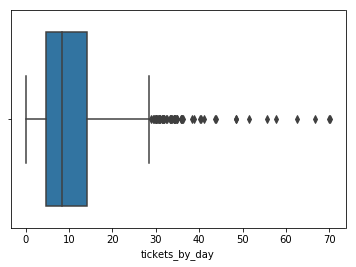

In [42]:
sns.boxplot(parkimeter_ticket_by_day);

### Construímos la serie de ocupación por timestamp

Construímos la tabla corta primero que usaremos para montar las series temporales:

In [43]:
df_coords.head()

,transaction_date_time,transaction_date,time_start,time_expired,duration_mins,amount,payment_mean,meter_code,element_key,final_date_time,latitude,longitude
transaction_id,,,,,,,,,,,,
14550137,2012-01-24 00:06:59,2012-01-24,00:06,02:06,120,4.00,CREDIT CARD,10269002,76986,2012-01-24 02:06:59,47.615013,-122.346506
14586857,2012-01-24 08:46:59,2012-01-24,08:46,09:16,30,1.00,COINS,10268002,76986,2012-01-24 09:16:59,47.615013,-122.346506
14586858,2012-01-24 09:42:59,2012-01-24,09:42,10:22,40,1.25,CREDIT CARD,10268002,76986,2012-01-24 10:22:59,47.615013,-122.346506
14589200,2012-01-24 12:19:59,2012-01-24,12:19,13:04,45,1.50,CREDIT CARD,10269002,76986,2012-01-24 13:04:59,47.615013,-122.346506
14586859,2012-01-24 12:21:59,2012-01-24,12:21,13:21,60,2.00,CREDIT CARD,10268002,76986,2012-01-24 13:21:59,47.615013,-122.346506


In [44]:
in_cols = ['element_key', 'transaction_date_time']
out_cols = ['element_key', 'final_date_time']

df_in = df_coords[in_cols].reset_index()
df_in.transaction_id = df_in.transaction_id.map(lambda s:'%s_in' % str(s))
df_in['timestamp_sign'] = 1.0
df_in.rename(columns={'transaction_date_time': 'timestamp'}, inplace=True)

df_out = df_coords[out_cols].reset_index()
df_out.transaction_id = df_out.transaction_id.map(lambda s:'%s_out' % str(s))
df_out['timestamp_sign'] = - 1.0
df_out.rename(columns={'final_date_time': 'timestamp'}, inplace=True)

In [45]:
df_in.head()

,transaction_id,element_key,timestamp,timestamp_sign
0,14550137_in,76986,2012-01-24 00:06:59,1.0
1,14586857_in,76986,2012-01-24 08:46:59,1.0
2,14586858_in,76986,2012-01-24 09:42:59,1.0
3,14589200_in,76986,2012-01-24 12:19:59,1.0
4,14586859_in,76986,2012-01-24 12:21:59,1.0


In [46]:
df_out.head()

,transaction_id,element_key,timestamp,timestamp_sign
0,14550137_out,76986,2012-01-24 02:06:59,-1.0
1,14586857_out,76986,2012-01-24 09:16:59,-1.0
2,14586858_out,76986,2012-01-24 10:22:59,-1.0
3,14589200_out,76986,2012-01-24 13:04:59,-1.0
4,14586859_out,76986,2012-01-24 13:21:59,-1.0


In [66]:
full_transactions = pd.concat([df_in, df_out])
full_transactions.set_index('transaction_id', inplace=True)
full_transactions.sort_values('timestamp', ascending=True, inplace=True)

In [67]:
full_transactions.timestamp.duplicated().mean()

0.8006312881860276

In [68]:
full_transactions.head()

,element_key,timestamp,timestamp_sign
transaction_id,,,
14550137_in,76986,2012-01-24 00:06:59,1.0
14580904_in,57194,2012-01-24 00:34:25,1.0
14580905_in,57194,2012-01-24 00:36:24,1.0
14574122_in,31498,2012-01-24 01:07:59,1.0
14555348_in,13093,2012-01-24 01:12:59,1.0


In [69]:
df_in.shape, df_out.shape, full_transactions.shape

((4864181, 4), (4864181, 4), (9728362, 3))

Comprobamos duplicados por parquímetro:

In [70]:
duplicated_timestamps_by_pk = full_transactions.groupby('element_key').timestamp.agg(lambda series: series.duplicated().mean())
duplicated_timestamps_by_pk.head()

element_key
1001    0.033840
1002    0.049411
1005    0.001176
1006    0.003364
1009    0.001130
Name: timestamp, dtype: float64

In [71]:
duplicated_timestamps_by_pk.quantile(np.linspace(0, 1, 21))

0.00    0.000000
0.05    0.000000
0.10    0.001087
0.15    0.001869
0.20    0.002712
0.25    0.003968
0.30    0.006181
0.35    0.011057
0.40    0.019592
0.45    0.025726
0.50    0.031842
0.55    0.036982
0.60    0.041642
0.65    0.046715
0.70    0.052314
0.75    0.057924
0.80    0.064523
0.85    0.075602
0.90    0.086146
0.95    0.107864
1.00    0.234224
Name: timestamp, dtype: float64

Agrupamos sumando por `element_key` para crear la ocupación en timestamp por parquímetro:

In [72]:
full_transactions['ocupation'] =  full_transactions.groupby('element_key').timestamp_sign.transform(lambda series: series.cumsum())

Limpiamos los duplicados por parquímetro seleccionando los valores últimos para que se hayan agregado las operaciones simultáneas

In [73]:
full_transactions.drop_duplicates(subset=['element_key', 'timestamp'], keep='last', inplace=True)

In [74]:
full_transactions.head(50)

,element_key,timestamp,timestamp_sign,ocupation
transaction_id,,,,
14550137_in,76986,2012-01-24 00:06:59,1.0,1.0
14580904_in,57194,2012-01-24 00:34:25,1.0,1.0
14580905_in,57194,2012-01-24 00:36:24,1.0,2.0
14574122_in,31498,2012-01-24 01:07:59,1.0,1.0
14555348_in,13093,2012-01-24 01:12:59,1.0,1.0
14557462_in,37177,2012-01-24 01:16:59,1.0,1.0
14568669_in,24405,2012-01-24 01:33:59,1.0,1.0
14553995_in,16942,2012-01-24 01:34:59,1.0,1.0
14580905_out,57194,2012-01-24 01:36:24,-1.0,1.0


In [75]:
full_transactions.to_csv(os.path.join(ct.PROCESSED_DATA, 'full_transactional_data_2012.csv'))

### Representamos algún parquímetro y EDA ocupacional

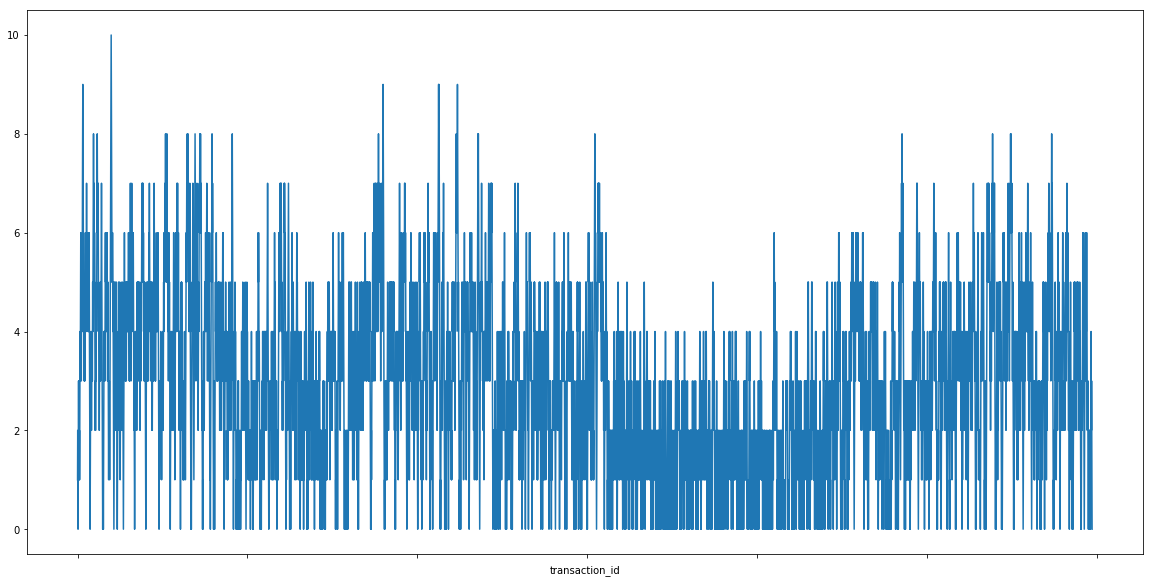

In [76]:
full_transactions.loc[full_transactions.element_key == 57194].ocupation.plot(figsize=(20, 10));

In [77]:
ocupation_stats = full_transactions.groupby('element_key').ocupation.describe().sort_values(by='count', ascending=False)
ocupation_stats.head(30)

,count,mean,std,min,25%,50%,75%,max
element_key,,,,,,,,
35845,38977.0,11.919106,4.198996,0.0,10.0,13.0,15.0,25.0
1234,38090.0,17.866763,5.798888,0.0,15.0,19.0,22.0,37.0
13213,37411.0,12.340354,4.253329,0.0,10.0,13.0,15.0,25.0
35850,34616.0,11.921279,4.792359,0.0,9.0,12.0,15.0,28.0
35846,33051.0,10.494448,3.866688,0.0,8.0,11.0,13.0,25.0
54737,31708.0,9.528289,4.099396,0.0,7.0,10.0,12.0,23.0
63125,28493.0,17.531604,8.905948,0.0,11.0,18.0,24.0,44.0
24406,27755.0,10.874797,5.100023,0.0,7.0,10.0,14.0,32.0
1233,25683.0,10.217498,3.743952,0.0,8.0,10.0,13.0,24.0


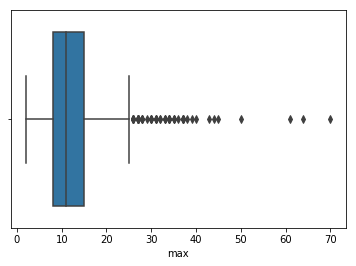

In [78]:
sns.boxplot(ocupation_stats['max'])

In [79]:
ocupation_stats['max'].quantile(np.linspace(0, 1, 21))

0.00     2.0
0.05     5.0
0.10     6.0
0.15     7.0
0.20     7.0
0.25     8.0
0.30     9.0
0.35     9.0
0.40    10.0
0.45    11.0
0.50    11.0
0.55    12.0
0.60    12.0
0.65    13.0
0.70    14.0
0.75    15.0
0.80    16.0
0.85    18.0
0.90    20.0
0.95    24.0
1.00    70.0
Name: max, dtype: float64

Ocupación a través de las horas del día:

In [80]:
full_transactions['hour'] = full_transactions.timestamp.dt.hour
ocupation_by_hour_key = full_transactions.groupby(['element_key', 'hour']).ocupation.describe()

In [81]:
ocupation_by_hour_key.head()

count      mean       std  min  25%  50%  75%  max
element_key hour                                                    
1001        0       1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
            7       2.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
            8       6.0  1.000000  0.632456  0.0  1.0  1.0  1.0  2.0
            9     164.0  1.640244  0.971288  0.0  1.0  1.0  2.0  5.0
            10    274.0  2.357664  1.486137  0.0  1.0  2.0  3.0  7.0

Realizamos gráficas:

- Agrupando primero por parquímetro y pintando media de ocupación por hora
- Agrupando primero por hora y una gráfica de la media de todos los parquímetros

### Frecuencia media de actualización de ocupación

La calculamos en minutos

In [82]:
update_frequency = full_transactions.groupby('element_key').timestamp.agg(lambda series: series.diff().mean().seconds / 60.0)

In [83]:
update_frequency.head()

element_key
1001    193.900000
1002     98.533333
1005    115.716667
1006     85.550000
1009    138.983333
Name: timestamp, dtype: float64

In [84]:
update_frequency.quantile(np.linspace(0, 1, 21))

0.00      12.650000
0.05      29.706667
0.10      36.553333
0.15      41.676667
0.20      48.246667
0.25      53.050000
0.30      59.290000
0.35      65.010000
0.40      72.350000
0.45      79.733333
0.50      87.066667
0.55      95.703333
0.60     105.546667
0.65     117.833333
0.70     134.143333
0.75     154.950000
0.80     178.090000
0.85     230.310000
0.90     313.526667
0.95     535.146667
1.00    1422.766667
Name: timestamp, dtype: float64

Hay series que tienen frecuencias realmente bajas

### Construímos la serie de ocupación agregada

Hay que ver cómo agregar por time deltas de 10 minutos o 30 minutos la serie temporal, viendo que hay bastante pocas actualizaciones en muchas de las series, igual el delta debería ser mayor.

Otra opción es trabajar con una librería que admita series irregularmente espaciadas.